In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Plot results against number of receivers

In [2]:
results_dir = Path("..") /  "results"
fname = results_dir / "benchmark_n-receivers.nc"

In [3]:
dataset = xr.load_dataset(fname)
dataset

<xarray.Dataset>
Dimensions:          (n_receivers: 7, simulation_type: 2, engine: 2, parallel: 2)
Coordinates:
  * n_receivers      (n_receivers) int32 100 400 900 1600 2500 3600 4900
  * simulation_type  (simulation_type) object 'ram' 'forward_only'
  * engine           (engine) object 'geoana' 'choclo'
  * parallel         (parallel) bool False True
Data variables:
    times            (parallel, simulation_type, engine, n_receivers) float64 ...
    errors           (parallel, simulation_type, engine, n_receivers) float64 ...

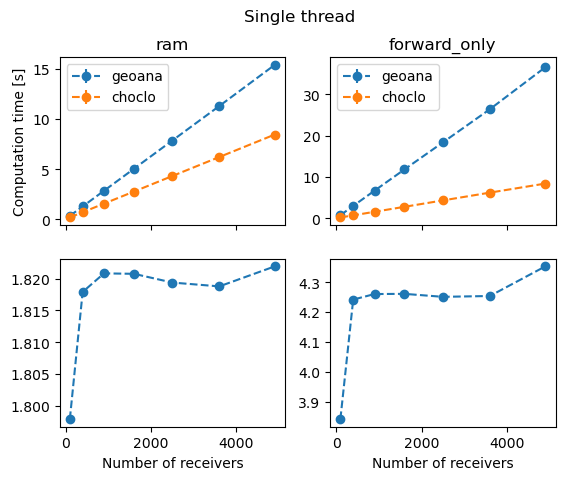

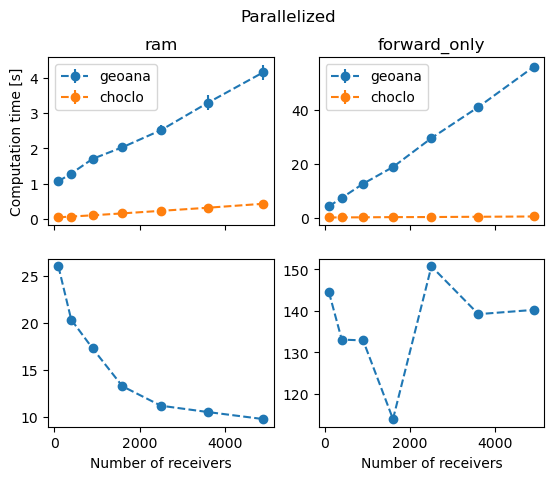

In [4]:
for parallel in (False, True):

    ncols, nrows = 2, 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True)
    if parallel:
        fig.suptitle("Parallelized")
    else:
        fig.suptitle("Single thread")

    for col, simulation_type in zip(range(ncols), dataset.simulation_type):

        # First row
        ax = axes[0, col]
        for engine in dataset.engine:
            results = dataset.sel(
                engine=engine, simulation_type=simulation_type, parallel=parallel
            )

            engine_str = str(engine.values)
            ax.errorbar(
                x=results.n_receivers,
                y=results.times,
                yerr=results.errors,
                marker="o",
                linestyle="dashed",
                label=engine_str,
            )
        ax.legend()
        ax.set_title(str(simulation_type.values))
        if col == 0:
            ax.set_ylabel("Computation time [s]")

        # Second row
        ax = axes[1, col]
        results = dataset.sel(simulation_type=simulation_type, parallel=parallel)

        relative = results.sel(engine="geoana").times / results.sel(engine="choclo").times

        engine_str = str(results.engine.values)
        ax.plot(
            relative.n_receivers,
            relative,
            marker="o",
            linestyle="dashed",
        )
        ax.set_xlabel("Number of receivers")

    plt.show()

# Plot results against number of cells in the mesh

In [5]:
results_dir = Path("..") /  "results"
fname = results_dir / "benchmark_n-cells.nc"

In [6]:
dataset = xr.load_dataset(fname)
dataset

<xarray.Dataset>
Dimensions:          (n_cells: 7, simulation_type: 2, engine: 2, parallel: 2)
Coordinates:
  * n_cells          (n_cells) int32 1000 8000 27000 64000 125000 216000 343000
  * simulation_type  (simulation_type) object 'ram' 'forward_only'
  * engine           (engine) object 'geoana' 'choclo'
  * parallel         (parallel) bool False True
Data variables:
    times            (parallel, simulation_type, engine, n_cells) float64 0.5...
    errors           (parallel, simulation_type, engine, n_cells) float64 0.0...

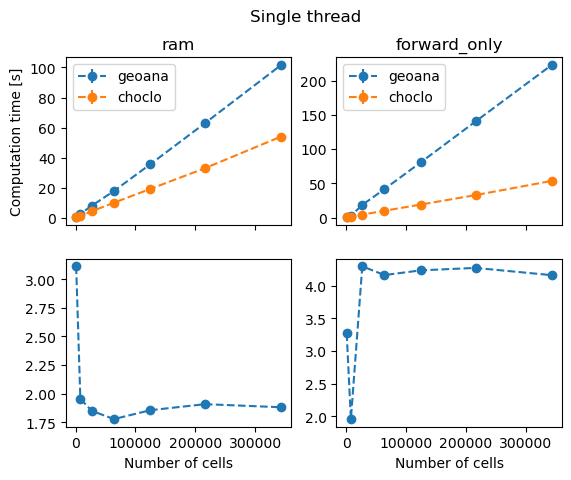

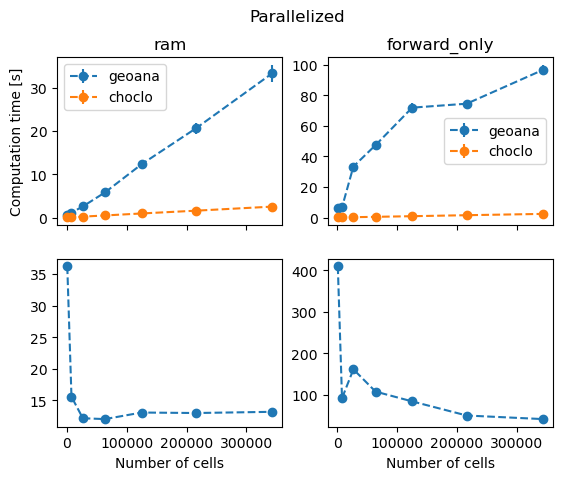

In [7]:
for parallel in (False, True):

    ncols, nrows = 2, 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True)
    if parallel:
        fig.suptitle("Parallelized")
    else:
        fig.suptitle("Single thread")

    for col, simulation_type in zip(range(ncols), dataset.simulation_type):

        # First row
        ax = axes[0, col]
        for engine in dataset.engine:
            results = dataset.sel(
                engine=engine, simulation_type=simulation_type, parallel=parallel
            )

            engine_str = str(engine.values)
            ax.errorbar(
                x=results.n_cells,
                y=results.times,
                yerr=results.errors,
                marker="o",
                linestyle="dashed",
                label=engine_str,
            )
        ax.legend()
        ax.set_title(str(simulation_type.values))
        if col == 0:
            ax.set_ylabel("Computation time [s]")

        # Second row
        ax = axes[1, col]
        results = dataset.sel(simulation_type=simulation_type, parallel=parallel)

        relative = results.sel(engine="geoana").times / results.sel(engine="choclo").times

        engine_str = str(results.engine.values)
        ax.plot(
            relative.n_cells,
            relative,
            marker="o",
            linestyle="dashed",
        )
        ax.set_xlabel("Number of cells")

    plt.show()